In [254]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#import kerastuner as kt
from sklearn.model_selection import train_test_split

In [351]:
# only the number of maxima
df_spectra_all=pd.read_csv("spectrum_energy_input_numberOfPeaks.csv",index_col=[0])
all_data = df_spectra_all[["k6a1","k6a2","k11","k12","k9a1","k9a2","no_of_max"]]
# drop all rows containing 0.5 to make it binary
print(len(all_data))
all_data = all_data.query('k6a1 != 0.5 & k6a2 != 0.5 & k11 != 0.5 & k12 != 0.5 & k9a1 != 0.5 & k9a2 != 0.5')
print(len(all_data))
#set the values to zero and one
#labels = ['k6a1','k6a2','k11','k12','k9a1','k9a2']
#[all_data[i].mask(all_data[i] == 0.25, 0, inplace=True) for i in labels]
#[all_data[i].mask(all_data[i] == 0.75, 1, inplace=True) for i in labels]
#print(all_data.head(10))
data_train, data_test = train_test_split(all_data, test_size=0.20, random_state=42)

729
64


In [352]:
feature_columns_A = []

no_of_max = tf.feature_column.numeric_column("no_of_max")
#my_feature_layer_A = tf.keras.layers.DenseFeatures(no_of_max_bucket)
feature_columns_A.append(no_of_max)
k11 = tf.feature_column.numeric_column("k11")
feature_columns_A.append(k11)
k12 = tf.feature_column.numeric_column("k12")
feature_columns_A.append(k12)
k9a1 = tf.feature_column.numeric_column("k9a1")
feature_columns_A.append(k9a1)
k9a2 = tf.feature_column.numeric_column("k9a2")
feature_columns_A.append(k9a2)

my_feature_layer_A = tf.keras.layers.DenseFeatures(feature_columns_A)

In [353]:
def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""  
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)
    plt.legend()

In [354]:
# for activation functions check https://keras.io/api/layers/activations/
def create_model2(my_learning_rate, my_feature_layer,my_metrics,my_act_function = "softmax"):
    model = tf.keras.models.Sequential()
    model.add(my_feature_layer)
    layers=[20,12]
    for layer in layers:
        model.add(tf.keras.layers.Dense(units = layer, activation = my_act_function))
    model.add(tf.keras.layers.Dense(units=6,name='Output', activation = 'softmax'))                             
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                       
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)
    return model


def train_model(model, dataset, epochs, label_name,
                batch_size=None,shuffle=True):
    features = {name:np.array(value) for name, value in dataset.items()}
    label=dataset[label_name].to_numpy()
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist

Train on 51 samples
Epoch 1/50
51/51 [==============================] - 2s 47ms/sample - loss: 1.0833 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.5196
Epoch 2/50
51/51 [==============================] - 0s 1ms/sample - loss: 1.0109 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.7026
Epoch 3/50
51/51 [==============================] - 0s 825us/sample - loss: 1.0077 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.7680
Epoch 4/50
51/51 [==============================] - 0s 952us/sample - loss: 1.0100 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.7647
Epoch 5/50
51/51 [==============================] - 0s 1ms/sample - loss: 1.0062 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.8824
Epoch 6/50
51/51 [==============================] - 0s 1ms/sample - loss: 1.0081 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.7614
Epoch 7/50
51/51 [==============================] - 0s 962us/sample - loss: 1.0064 - accuracy: 0.0000e+00 - precision: 1.0000 - r

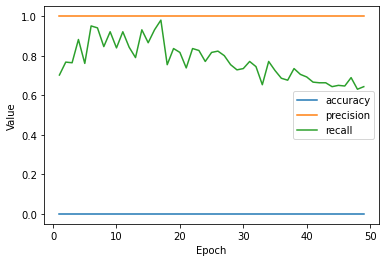

In [355]:
learning_rate = 1e-2
epochs = 50
batch_size = 12

#specify the classification threshold
classification_threshold = 0.15

# Establish the metrics the model will measure.
metric = [tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,name='precision'),
      tf.keras.metrics.Recall(thresholds=classification_threshold,name='recall'),]

label_name = ["k6a1","k6a2","k11","k12","k9a1","k9a2"]
#label_name = "k6a1"
my_model = create_model2(learning_rate, my_feature_layer_A,metric,my_act_function="sigmoid")
epochs, hist = train_model(my_model, data_train, epochs, 
                          label_name, batch_size)
# Plot a graph of the metric(s) vs. epochs.
#list_of_metrics_to_plot = ['accuracy'] 
list_of_metrics_to_plot = ['accuracy', 'precision', 'recall'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

In [350]:
features = {name:np.array(value) for name, value in data_test.items()}
label=data_test[label_name].to_numpy()
print("\n Evaluate the new model against the test set:")
evaluation=my_model.evaluate(x = features, y = label, batch_size=batch_size)
predicted = my_model.predict(features)
print(predicted)
df_test=pd.DataFrame(label,columns=["k6a1_test","k6a2_test","k11_test","k12_test","k9a1_test","k9a2_test"])
#df_test=pd.DataFrame(label,columns=["k6a1_test"])
df_predict=pd.DataFrame(predicted,columns=["k6a1_hat","k6a2_hat","k11_hat","k12_hat","k9a1_hat","k9a2_hat"])
#df_predict=pd.DataFrame(predicted,columns=["k6a1_hat"])
#df_test = df_test.round(0)
#df_predict = df_predict.round(0)
pd.concat([df_test,df_predict], axis=1).head()


 Evaluate the new model against the test set:
13/1 [======================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 852us/sample - loss: 0.8579 - accuracy: 0.0000e+00 - precision: 1.0000 - recall: 0.5513
[[0.13655457 0.17596427 0.16525982 0.26237363 0.14800842 0.11183929]
 [0.14511466 0.15023044 0.232265   0.15708901 0.14270364 0.17259729]
 [0.16751677 0.17861402 0.15458232 0.16845924 0.16583404 0.16499366]
 [0.11532    0.14389776 0.29317856 0.24952509 0.09801608 0.10006253]
 [0.14162816 0.16428527 0.15988643 0.18285441 0.15954997 0.1917958 ]
 [0.13871638 0.17749234 0.164097   0.26046348 0.14813651 0.11109424]
 [0.17003666 0.18009403 0.1531572  0.16741246 0.

,k6a1_test,k6a2_test,k11_test,k12_test,k9a1_test,k9a2_test,k6a1_hat,k6a2_hat,k11_hat,k12_hat,k9a1_hat,k9a2_hat
0,0.75,0.75,0.25,0.75,0.25,0.25,0.136555,0.175964,0.165260,0.262374,0.148008,0.111839
1,0.75,0.75,0.75,0.25,0.75,0.25,0.145115,0.150230,0.232265,0.157089,0.142704,0.172597
2,0.25,0.25,0.25,0.25,0.25,0.25,0.167517,0.178614,0.154582,0.168459,0.165834,0.164994
3,0.75,0.25,0.75,0.75,0.25,0.25,0.115320,0.143898,0.293179,0.249525,0.098016,0.100063
4,0.25,0.25,0.25,0.75,0.25,0.75,0.141628,0.164285,0.159886,0.182854,0.159550,0.191796


# Umbauen in ein echtes Klassifizierungsproblem

see https://sebastianraschka.com/faq/docs/softmax_regression.html

Wir haben für jede Konstante drei mögliche Werte: 0.25, 0.5 und 0.75 - das ist somit ein "ternary" (dreifaltiges?) Klassifikationsproblem. Die softmax Funktion am Ende des Modells gibt eine Wahrscheinlichkeit an, inwiefern das "feature" zu welcher Klasse gehört (prozentual). 

Ich würde mal anfangen und für k6a1 ein Modell bauen mit one-hot encoding für die drei möglichen Werte und als feature die Anzahl der Peaks. Das gleiche für ausschliesslich k6a2, k11, k12, k9a1, k9a2. Vermutlich wird das nicht so gut funktionieren weil die Information einfach nicht ausreichend ist. Da würde ich mal versuchen zu verstehen, welche Vorhersagen dir das Modell gibt, und dass du die Wahrscheinlichkeiten für die drei möglichen Klassen bekommst, für jedes Beispiel.

Im zweiten Schritt würde ich dann andere Klassen-Kombinationen probieren:
Klasse 1 - k6a1, k11, k9a1 
Klasse 2 - k6a2, k12, k9a2 

Sagen wir, die jeweiligen Werte liegen bei -1 (momentan 0.25), 0 (momentan 0.5), 1 (momentan 0.75). Die Summe aller Werte liegt damit zwischen -3 und +3.

Dann wäre Fall A: sum(Klasse 1) < -1; Fall B: -1 < sum(Klasse 1) < 1; Fall C: sum(Klasse 1) > 1. Mit den Grenzen kann man etwas herumspielen; und das gleiche jeweils für Klasse 2.

Oder vielleicht hast du noch andere Ideen.